In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math

import os
import sys
from numpy.fft import fft, ifft
import glob

In [62]:
def remove_periodic(X, df_index, detrending=True, model='additive', frequency_threshold=0.1e12):
    rad = np.array(X)
    
    if detrending:
        det_rad = rad - np.average(rad)
    else:
        det_rad = rad
    
    det_rad_fft = fft(det_rad)

    # Get the power spectrum
    rad_ps = [np.abs(rd)**2 for rd in det_rad_fft]
    
    clean_rad_fft = [det_rad_fft[i] if rad_ps[i] > frequency_threshold else 0 
                     for i in range(len(det_rad_fft))]
    
    rad_series_clean = ifft(clean_rad_fft)
    rad_series_clean = [value.real for value in rad_series_clean]
    
    if detrending:
        rad_trends = rad_series_clean + np.average(rad)
    else:
        rad_trends = rad_series_clean
        
    rad_clean_ts = pd.Series(rad_trends, index=df_index)
    
    #rad_clean_ts[(rad_clean_ts.index.hour < 6) | (rad_clean_ts.index.hour > 20)] = 0
    residual = rad - rad_clean_ts.values
    clean = rad_clean_ts.values
    return residual, clean

In [3]:
def normalized_rmse(targets, forecasts):
    if isinstance(targets, list):
        targets = np.array(targets)
    if isinstance(forecasts, list):
        forecasts = np.array(forecasts)
    return ((np.sqrt(np.nanmean((targets - forecasts) ** 2))) / np.nanmean(targets) ) * 100


In [4]:
def load_data(path, resampling=None):
    ## some resampling options: 'H' - hourly, '15min' - 15 minutes, 'M' - montlhy
    ## more options at:
    ## http://benalexkeen.com/resampling-time-series-data-with-pandas/
    allFiles = glob.iglob(path + "/**/*.txt", recursive=True)
    frame = pd.DataFrame()
    list_ = []
    for file_ in allFiles:
        #print("Reading: ",file_)
        df = pd.read_csv(file_,index_col="datetime",parse_dates=['datetime'], header=0, sep=",")
        if frame.columns is None :
            frame.columns = df.columns
        list_.append(df)
    frame = pd.concat(list_)
    if resampling is not None:
        frame = frame.resample(resampling).mean()
    frame = frame.fillna(method='ffill')
    return frame

In [5]:
path = '/Users/cseveriano/spatio-temporal-forecasting/data/processed/NREL/Oahu'

df = load_data(path)

# Corrigir ordem das colunas
df.columns = ['DHHL_3','DHHL_4', 'DHHL_5', 'DHHL_10', 'DHHL_11', 'DHHL_9', 'DHHL_2', 'DHHL_1', 'DHHL_1_Tilt', 'AP_6', 'AP_6_Tilt', 'AP_1', 'AP_3', 'AP_5', 'AP_4', 'AP_7', 'DHHL_6', 'DHHL_7', 'DHHL_8']

In [6]:
#inicio dos dados possui falhas na medicao
df = df.loc[df.index > '2010-03-20']

In [7]:
len(df.loc[df.AP_7 < 0].index)

649

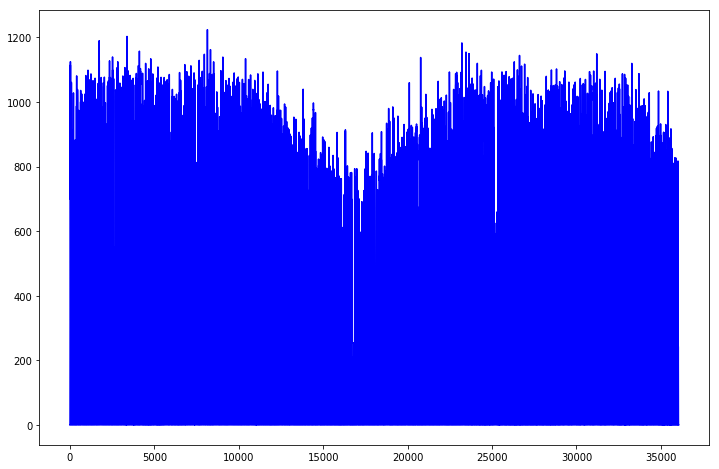

In [9]:
fig = plt.figure(figsize=(12, 8))
plt.plot(df.DHHL_8.values, color='blue')
plt.show()

## Preparação caso de teste de Aryaputeras et al. - Observed Station

In [77]:
clean_df = pd.DataFrame(columns=df.columns, index=df.index)
residual_df = pd.DataFrame(columns=df.columns, index=df.index)

for col in df.columns:
    residual, clean = remove_periodic(df[col].tolist(), df.index, frequency_threshold=0.01e12)
    clean_df[col] = clean.tolist()
    residual_df[col] = residual.tolist()

In [79]:
train_df = df[(df.index >= '2010-09-01') & (df.index <= '2011-09-01')]
train_clean_df = clean_df[(clean_df.index >= '2010-09-01') & (clean_df.index <= '2011-09-01')]
train_residual_df = residual_df[(residual_df.index >= '2010-09-01') & (residual_df.index <= '2011-09-01')]


test_df = df[(df.index >= '2010-08-05')& (df.index < '2010-08-06')]
test_clean_df = clean_df[(clean_df.index >= '2010-08-05')& (clean_df.index < '2010-08-06')]
test_residual_df = residual_df[(residual_df.index >= '2010-08-05')& (residual_df.index < '2010-08-06')]

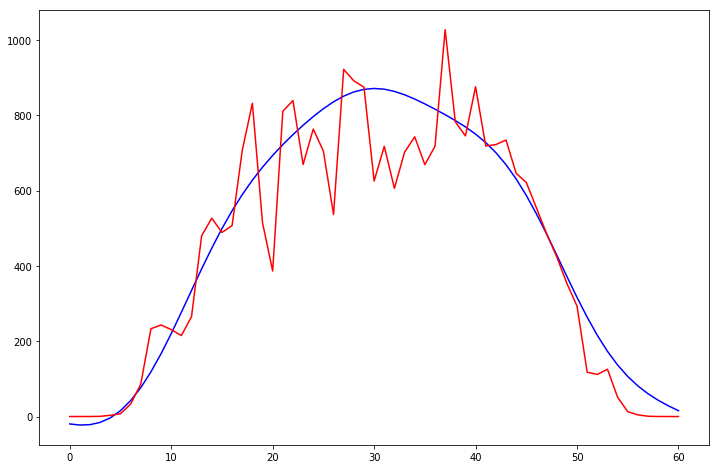

In [81]:
fig = plt.figure(figsize=(12, 8))
plt.plot(test_clean_df.DHHL_3.values, color='blue')
plt.plot(test_df.DHHL_3.values, color='red')
plt.show()

## Análise VAR

In [17]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, DynamicVAR

/Users/cseveriano/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [18]:
model = VAR(train_df)
results = model.fit(maxlags=6, ic='aic')

In [28]:
order = results.k_ar
forecast = []
for i in range(len(test_df)-order) :
    forecast.append(results.forecast(test_df.values[i:i+order],1))

In [44]:
fcst = [item[0] for item in forecast]
df_forecast = pd.DataFrame(data=fcst, columns=test_df.columns)

In [50]:
len(test_df)

61

In [51]:
for col in test_df.columns:
    _rmse = normalized_rmse(test_df[col][order:].tolist(), df_forecast[col].tolist())
    print("Col "+ col + " - nRMSE: ", _rmse, "\n")

Col DHHL_3 - nRMSE:  21.5708141007 

Col DHHL_4 - nRMSE:  20.7566365986 

Col DHHL_5 - nRMSE:  20.9770564186 

Col DHHL_10 - nRMSE:  21.3021905618 

Col DHHL_11 - nRMSE:  23.2656333697 

Col DHHL_9 - nRMSE:  21.3885489118 

Col DHHL_2 - nRMSE:  21.8586253266 

Col DHHL_1 - nRMSE:  20.7177568996 

Col DHHL_1_Tilt - nRMSE:  18.7785128417 

Col AP_6 - nRMSE:  25.6748215925 

Col AP_6_Tilt - nRMSE:  23.3989681669 

Col AP_1 - nRMSE:  21.0102058576 

Col AP_3 - nRMSE:  31.53281367 

Col AP_5 - nRMSE:  26.5006367125 

Col AP_4 - nRMSE:  27.4624233419 

Col AP_7 - nRMSE:  24.8528457607 

Col DHHL_6 - nRMSE:  20.4949629554 

Col DHHL_7 - nRMSE:  21.7987008807 

Col DHHL_8 - nRMSE:  22.3952814575 



## Persistence

In [82]:
def persistence(irradiance, clear_sky):
    
    _predI = []
    
    for i in range(0,len(irradiance)-1):
        if clear_sky[i] != 0:
            kt = irradiance[i]/clear_sky[i]
            pred = kt * clear_sky[i+1]
        else:
            pred = 0
        
        _predI.append(pred)
    
    return _predI

In [84]:
df_persistencte_forecast = pd.DataFrame(columns=test_df.columns)

for col in test_df.columns :
    df_persistencte_forecast[col] = persistence(test_df[col].tolist(), test_clean_df[col].tolist())    

In [85]:
df_persistencte_forecast

,DHHL_3,DHHL_4,DHHL_5,DHHL_10,DHHL_11,DHHL_9,DHHL_2,DHHL_1,DHHL_1_Tilt,AP_6,AP_6_Tilt,AP_1,AP_3,AP_5,AP_4,AP_7,DHHL_6,DHHL_7,DHHL_8
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.221685,-0.131703,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.001055,-0.113505
1,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.254809,-0.280587,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000746,-0.170366
2,0.000000,-0.000000,0.000360,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.084585,-0.132459,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000617,-0.089376
3,0.106434,1.742315,-0.629587,2.163607,1.047366,0.479475,0.081960,9.836173,0.330741,-0.192766,0.497688,0.298279,2.838086,4.055707,0.857625,9.622583,0.798161,-1.403903,0.792908
4,-13.929323,8.054347,12.673668,8.441625,6.474743,4.739484,-23.240404,8.210581,2.330415,27.777743,2.589330,-5.215104,-2.705521,8.511352,6.692978,-5.360342,5.732128,12.119389,5.150449
5,20.425471,14.272854,16.662773,15.191393,12.880370,11.542467,20.264488,14.556882,6.860816,19.197505,7.056238,-4.095262,4.617813,15.170508,13.485277,6.723213,12.594959,17.715415,11.341764
6,59.771989,53.562019,60.313344,53.102288,46.114804,45.834206,30.515530,48.883548,11.654863,62.104657,13.730453,-6.709850,-579.174436,57.327460,62.018527,6.461471,48.029981,62.189242,37.292435
7,133.386286,121.976812,144.126388,118.503138,95.860500,91.062821,142.745643,107.414371,19.536156,166.333952,27.679234,1377.313837,89.931854,121.656571,160.596803,601.347532,99.110608,118.531482,83.878434
8,328.245504,313.566377,324.675676,319.954772,312.033316,303.975368,317.239090,323.780229,42.406452,316.055100,58.682251,371.582507,288.641591,320.281636,318.924590,186.099888,300.376579,326.404694,295.795125
9,320.806846,309.775964,311.928157,316.557580,311.577314,304.432238,308.017911,316.771185,33.237119,292.632519,50.102826,144.384583,401.672014,322.178234,313.839674,49.636123,306.185164,320.003880,298.009353


In [86]:
for col in test_df.columns:
    _rmse = normalized_rmse(test_df[col][1:].tolist(), df_persistencte_forecast[col].tolist())
    print("Col "+ col + " - nRMSE: ", _rmse, "\n")

Col DHHL_3 - nRMSE:  28.4315341446 

Col DHHL_4 - nRMSE:  26.8169952891 

Col DHHL_5 - nRMSE:  26.336423913 

Col DHHL_10 - nRMSE:  28.0520740285 

Col DHHL_11 - nRMSE:  29.9229555989 

Col DHHL_9 - nRMSE:  26.9110162368 

Col DHHL_2 - nRMSE:  24.4358650211 

Col DHHL_1 - nRMSE:  21.0160122798 

Col DHHL_1_Tilt - nRMSE:  21.7854745148 

Col AP_6 - nRMSE:  32.4327713938 

Col AP_6_Tilt - nRMSE:  28.4844759169 

Col AP_1 - nRMSE:  50.114933123 

Col AP_3 - nRMSE:  44.157927145 

Col AP_5 - nRMSE:  33.6057322536 

Col AP_4 - nRMSE:  33.8094360969 

Col AP_7 - nRMSE:  45.7926680057 

Col DHHL_6 - nRMSE:  26.7779122441 

Col DHHL_7 - nRMSE:  23.8669644355 

Col DHHL_8 - nRMSE:  29.1314256216 



## High order FTS

In [87]:
from pyFTS.models.multivariate import common, variable, mvfts
from pyFTS.models.seasonal import partitioner as seasonal
from pyFTS.models.seasonal.common import DateTime
from pyFTS.partitioners import Grid, Util as pUtil
from pyFTS.models.multivariate import common, variable, mvfts
from pyFTS.models import hofts

In [103]:
_order = 6

for col in train_df.columns:
    train = train_df[col]
    
    print("Training: "+ col + "\n")
    fuzzy_sets = Grid.GridPartitioner(data=train, npart=100)
    model_hofts = hofts.HighOrderFTS("FTS",  partitioner=fuzzy_sets)
    model_hofts.fit(train, order=_order)
    
    test = test_df[col]
    
    forecast_hofts = model_hofts.predict(test)
    _nrmse = normalized_rmse(test.tolist()[(order-1):], forecast_hofts)
    print("Col "+ col + " - nRMSE: ", _nrmse, "\n")

Training: DHHL_3

Col DHHL_3 - nRMSE:  4.43296550261 

Training: DHHL_4

Col DHHL_4 - nRMSE:  3.80538615105 

Training: DHHL_5

Col DHHL_5 - nRMSE:  5.03357499168 

Training: DHHL_10

Col DHHL_10 - nRMSE:  3.91648095987 

Training: DHHL_11

Col DHHL_11 - nRMSE:  3.90470446207 

Training: DHHL_9

Col DHHL_9 - nRMSE:  3.93802532522 

Training: DHHL_2

Col DHHL_2 - nRMSE:  4.38125698594 

Training: DHHL_1

Col DHHL_1 - nRMSE:  4.62068110495 

Training: DHHL_1_Tilt

Col DHHL_1_Tilt - nRMSE:  3.55302671965 

Training: AP_6

Col AP_6 - nRMSE:  4.05648575745 

Training: AP_6_Tilt

Col AP_6_Tilt - nRMSE:  5.17478732654 

Training: AP_1

Col AP_1 - nRMSE:  4.17740867129 

Training: AP_3

Col AP_3 - nRMSE:  10913.3493511 

Training: AP_5

Col AP_5 - nRMSE:  3.55313526808 

Training: AP_4

Col AP_4 - nRMSE:  3.62668266491 

Training: AP_7

Col AP_7 - nRMSE:  4.48261188524 

Training: DHHL_6

Col DHHL_6 - nRMSE:  3.69891867619 

Training: DHHL_7

Col DHHL_7 - nRMSE:  3.67686012375 

Training: DHHL